Initial potential energy  -15.243554429665819
Initial kinetic energy  28.799999999999997


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: invalid value encountered in multiply


elapsed time: 120.83 seconds, performance 49.66 steps/second


<IPython.core.display.Javascript object>


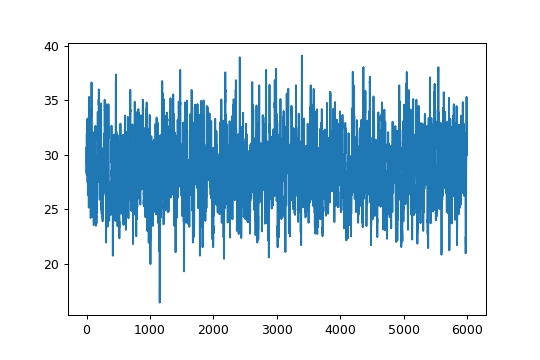

<IPython.core.display.Javascript object>


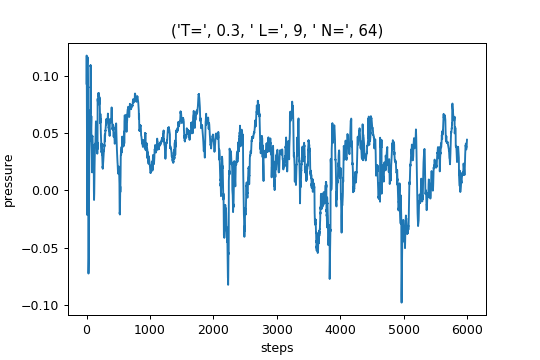

0.020965589759315655


In [63]:

# many functions are from Prof. Statt's code

import numpy as np 
import time 
import math
import scipy.spatial
from scipy.spatial import cKDTree as KDTree
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

def kinetic_energy(m, v):
    """
    args:
        m (float): mass of particles
        v (array): velocities of particles,
        assumed to be a 2D array of shape (N, 3)
    returns:
        float: total kinetic energy
    """
    total_vsq = np.einsum('ij,ij', v, v)
    return 0.5*m*total_vsq

def my_pos_in_box(pos, lbox):
    """ wrap positions inside simulation box

    Args:
    pos (np.array): positions, shape (natom, ndim)
    lbox (float): box side length
    Returns:
    np.array: pos in box
    """
    N=len(pos)
    L=lbox
    pos=pos-0.5*L
    a=pos//L
    b=pos%L
    pos_in_box=b-0.5*L
    return pos_in_box

def potential_energy(pos, rc, L):
    """
    args:
        dist (array): distance table with shape (N, N)
            i.e. dist[i,j] is the distance
            between particle i and particle j
            in the minimum image convention
            note that the diagonal of dist can be zero
        rc (float): cutoff distance for interaction
            i.e. if dist[i,j] > rc, the pair potential between
            i and j will be 0
        L: box length 
    returns:
        float: total potential energy
    """
    # dist = scipy.spatial.distance.pdist(pos) 
    # dist = np.where(dist > 0.5*L, dist-L, np.where(dist < -0.5*L, dist+L , dist))

    table = pos[:,np.newaxis,:] - pos[np.newaxis,:,:]
    dist_vec = minimum_image(table,L) 
    dist_vec[np.diag_indices(len(dist_vec))] = np.inf
    r = np.linalg.norm(dist_vec,axis=-1)
    
    v = 4*((1/r)**12-(1/r)**6)
    vc = 4*((1/rc)**12-(1/rc)**6)
    v[r < rc] -= vc #shift
    v[r >= rc] = 0 #cut
    return 0.5*np.sum(v)

def minimum_image(r, L):
    """
    args:
        r : array of any shape
        L : box size
    returns:
        array of the same shape as r,
        the minimum image of r
    """
    return r - L*np.round(r / L)

def initial_positions(N,radius,L):
    """ 
    Simple helper function to generate fcc positions 
    
    args: 
        N (int): number of particles 
        L (float): side length of cubic box
        radius (float): distance on lattice 
    returns:
        array of shape (N,3) with particle positions on fcc lattice 
     """
    a = radius*np.sqrt(2)*2
    S = list(np.arange(-L/2.,L/2.-a, a))
   
    FCC = list(itertools.product(S,S,S))
    FCC = np.vstack((FCC,
            FCC+a/2.*np.array([1,1,0]),
            FCC+a/2.*np.array([1,0,1]),
            FCC+a/2.*np.array([0,1,1])
            ))
    
    q = np.random.choice(len(FCC),N,replace=False)
    return FCC[q]

def initial_velocities(N, m, T):
    """
    initialize velocities at a desired temperature
    required for: initialization

    args:
        N (int): number of particles
        m (float): mass of particles
        T (float): desired temperature
    returns:
        array: initial velocities, with shape (N, 3)
    """
    velocities = np.random.rand(N,3)-0.5
    #zero the total net velocity
    velocities -= np.average(velocities,axis=0)
    # correct temperature
    current_temp = 2*kinetic_energy(m,velocities)/(3*N)
    velocities *= np.sqrt(T / current_temp)
    return velocities

def velocity_verlet(force_func,pos,vel,mass,dt,rc,L):
    """
    advance system according to velocity verlet

    args:
        force_func: a function that calculates all forces between all particles 
        pos (array): coordinates of particles
        vel (array): velocities of particles
        mass (float): mass of particles
        dt (float): timestep by which to advance

        rc (float): cutoff
        L (float): length of cubic box
    returns:
        array, array: new positions, new velocities
    """ 
    
    accel = force_func(pos,rc,L) / mass
    #move
    vel_half = vel + 0.5*dt*accel
    pos_new = pos + dt*vel_half
    pos_new = minimum_image(pos_new, L)
    
    #repeat force calculation for new pos
    accel = force_func(pos_new,rc,L) / mass
    #finish move
    vel_new = vel_half + 0.5*dt*accel
    
    return pos_new, vel_new

def force_smarter(pos,rc,L):
    """
    calculate forces for all particles in system 
    args:
        pos (array): all positions, shape (N,3)
        rc (float): cutoff distance for interaction
        i.e. if dist[i,j] > rc, particle i will feel no force
        from particle j
        L (float): box size 
    returns:
        array: forces f on all particles, with shape (N, 3)
        i.e. f[3,0] gives the force on particle i
        in the x direction
    """
    table = pos[:,np.newaxis,:] - pos[np.newaxis,:,:]
    dist_vec = minimum_image(table,L) 
    dist_vec[np.diag_indices(len(dist_vec))] = np.inf
    r_len = np.linalg.norm(dist_vec,axis=-1)
    one_over_r_squared = 1./pow(r_len,2)
    one_over_r_six = pow(one_over_r_squared,3)
    magnitude = 24.*one_over_r_six*one_over_r_squared*(2.*one_over_r_six - 1)
    magnitude[r_len >= rc] = 0
    val = magnitude[:,:,np.newaxis]*dist_vec
    val = np.nansum(val, axis=1)
    
    return val 

def displacement_table(coordinates, L):
    """
    required for: force(), advance()
    args:
        coordinates (array): coordinates of particles,
        assumed to have shape (N, 3)
        e.g. coordinates[3,0] should give the x component
        of particle 3
        L (float): side length of cubic box,
        must be known in order to compute minimum image
    returns:
        array: table of displacements r
        such that r[i,j] is the minimum image of
        coordinates[i] - coordinates[j]
    """
    #coordinates=np.array(coordinates)
    coordinates=my_pos_in_box(coordinates,L)
    #print(coordinates)
    #coordinates=coordinates.tolist()
    N=len(coordinates)
    r=np.zeros((N,N,3))
    
    for i in range(N):
        for j in range(N):
            r[i][j][0]=coordinates[i][0]-coordinates[j][0]
            r[i][j][1]=coordinates[i][1]-coordinates[j][1]
            r[i][j][2]=coordinates[i][2]-coordinates[j][2]
        r[i]=minimum_image(r[i],L)
    #print(r)
    return r

def pressure(pos, force, V, T):
    N = len(pos)
    P = N*T/V
    for i in range(N):
        P = P+np.dot(pos[i],force[i])/(3*V)
    return P  


N = 64
Lbox = 9
L = Lbox
T = 0.3
mass = 1.0
dt = 0.003
rc = 3
sigma=1.123 # diameter of the particles
V = Lbox**3


pos = initial_positions(N,0.5,Lbox)
vel = initial_velocities(N,mass,T)

p = potential_energy(pos,rc,Lbox)
k = kinetic_energy(mass,vel)


print("Initial potential energy ",p)
print("Initial kinetic energy ",k)

PE = []
KE = []
start = time.time()
Nsteps=6000
P = []
for i in range(Nsteps):
    
    pos,vel = advance(pos, vel, sigma, L, force_smarter, mass, dt, rc)
    #print(pos)
    # below is the thermostat
    for i in range(64):
        f=np.random.rand()
        e=np.random.normal(loc=0,scale=np.sqrt(T/mass),size=3)
        if f<0.2:
            vel[i]=e
    # above is the thermostat
    PE.append(potential_energy(pos,rc,Lbox))
    KE.append(kinetic_energy(mass,vel))
    force = force_smarter(pos,rc,L)
    pres = pressure(pos, force, V, T)
    P.append(pres)
end = time.time()
total_time =(end - start)
print('elapsed time: %3.2f seconds, performance %3.2f steps/second' % (total_time,Nsteps/total_time))

#print(np.add(PE,KE))
plt.figure()
plt.plot(KE)
plt.figure()
plt.plot(P)
plt.xlabel('steps')
plt.ylabel('pressure')
pltitle = 'T=',T,' L=',L,' N=',N
plt.title(pltitle)

print(np.average(P[2000::]))

In [62]:

print(np.average(P[4000::]))

0.0292709359775019
